In [ ]:
import os
import sys
import numpy as np
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Import utility functions
from utils import (
    load_data, 
    compute_log_returns, 
    directional_accuracy,
    compute_realized_volatility,
    build_sequences
)

# Add the path to the custom library to the system path
sys.path.append(str(Path().resolve().parent))

# Import the module from the custom library
from src.models.data_loader import DataLoader
from src.models import TrainingArguments, LabeledData
from src.architectures.transformer import DecoderTransformer
from src.core.utils import data_analysis, data_processing, context_manager
from src import Tensor, layers, loss_functions, optimizers, metrics, callbacks
from src.architectures.auto_regressive import AutoRegressive, AutoRegressiveConfig
from src.architectures.transformer.config import TransformerConfig, TransformerBlockConfig, MLPConfig, AttentionConfig

### Constants and Hyperparameters

In [2]:
# Path to where the model will be saved
model_path = os.path.join(os.getcwd(), 'checkpoints', 'stock_prediction_transformer')
dataset_path = os.path.join(os.getcwd(), 'dataset', 'SPX.csv')

# Define the feature and target columns
feature_columns = ['Open', 'High', 'Low', 'Close']
close_price_idx = feature_columns.index('Close')

In [3]:
# Hyperparameters for the model
train_test_split_pct = 0.05
train_valid_split_pct = 0.1
n_attention_heads = 4
n_decoder_blocks = 4
learning_rate = 5e-4
max_seq_len = 128
dropout_rate = 0.1
batch_size = 32
epochs = 50
n_embed = 64
seed = 1234

# Volatility window size (number of periods to compute realized volatility)
volatility_window = 5

In [4]:
# Set the seed for reproducibility
np.random.seed(seed)

### Data loading

In [5]:
# Load the data
data = load_data(dataset_path)

# Print the number of data points and the date range
print(f"Loaded {len(data)} data points")
print(f"Date range: {data[0]['Date']} to {data[-1]['Date']}")

Loaded 23323 data points
Date range: 1927-12-30 to 2020-11-04


In [6]:
# Extract the feature and timestamp data
features = np.array([[np.float32(data[j][k]) for k in feature_columns] for j in range(len(data))])
timestamps = np.array([datetime.strptime(data[j]['Date'], '%Y-%m-%d').timestamp() for j in range(len(data))], dtype=np.int32)

# Print the shapes of the features and dates arrays
print(f"Price data shape: {features.shape}")
print(f"Timestamps shape: {timestamps.shape}")

Price data shape: (23323, 4)
Timestamps shape: (23323,)


### Features engineering

In [7]:
# Compute log returns
log_returns = compute_log_returns(features)
timestamps_returns = timestamps[1:]

# Print the shape and statistics of the log returns
print(f"Log returns shape: {log_returns.shape}")
print(f"Log returns stats - Mean: {np.mean(log_returns, axis=0)}")
print(f"Log returns stats - Std: {np.std(log_returns, axis=0)}")

# Compute realized volatility using a rolling window
realized_volatility = compute_realized_volatility(log_returns, volatility_window)

# Adjust timestamp for the volatility data
timestamps_volatility = timestamps_returns[volatility_window:]

# Print the shape and statistics of the realized volatility
print(f"\nRealized volatility shape: {realized_volatility.shape}")
print(f"Realized volatility stats - Mean: {np.mean(realized_volatility, axis=0)}")
print(f"Realized volatility stats - Std: {np.std(realized_volatility, axis=0)}")

Log returns shape: (23322, 4)
Log returns stats - Mean: [0.00022563 0.00022662 0.00022561 0.00022609]
Log returns stats - Std: [0.01179839 0.01105997 0.01168979 0.01202147]

Realized volatility shape: (23317, 4)
Realized volatility stats - Mean: [0.00917469 0.00854306 0.00900207 0.00929485]
Realized volatility stats - Std: [0.00742147 0.00702609 0.00746039 0.00762645]


### Data preprocessing

In [8]:
# Build sequences
features_data, targets_data, timestamps_returns_data = build_sequences(
    input_data = log_returns[volatility_window:],
    target_data = realized_volatility,
    timestamps = timestamps_volatility,
    seq_length = max_seq_len
    
)

# Convert to tensors
features, targets, timestamps = Tensor(features_data), Tensor(targets_data), Tensor(timestamps_returns_data)

# Print the shapes of the features and targets
print(f"Features shape: {features.shape}")
print(f"Targets shape: {targets.shape}")
print(f"Timestamps shape: {timestamps.shape}")

Features shape: (23189, 128, 4)
Targets shape: (23189, 4)
Timestamps shape: (23189,)


### Data splitting

In [9]:
# Split the dataset into training, validation, and testing sets
(X_train, X_test, y_train, y_test), train_test_shuffle_indices = data_processing.split_data((features, targets), train_test_split_pct, shuffle=True)
(X_train, X_valid, y_train, y_valid), train_valid_shuffle_indices = data_processing.split_data((X_train, y_train), train_valid_split_pct, shuffle=True)

# Ensure the shuffle indices are numpy arrays
assert isinstance(train_test_shuffle_indices, np.ndarray), "train_test_shuffle_indices should be a numpy array"
assert isinstance(train_valid_shuffle_indices, np.ndarray), "train_valid_shuffle_indices should be a numpy array"

# Extract the timestamps for each set
train_timestamps, test_timestamps = data_processing.split_data(timestamps[train_test_shuffle_indices], train_test_split_pct, shuffle=False)[0]
train_timestamps, valid_timestamps = data_processing.split_data(train_timestamps[train_valid_shuffle_indices], train_valid_split_pct, shuffle=False)[0]

# Print the dataset information
print('Training set:', X_train.shape, y_train.shape)
print('Validation set:', X_valid.shape, y_valid.shape)
print('Testing set:', X_test.shape, y_test.shape)

Training set: (19827, 128, 4) (19827, 4)
Validation set: (2203, 128, 4) (2203, 4)
Testing set: (1159, 128, 4) (1159, 4)


### Data normalization

In [10]:
# Compute normalization statistics from training data only
mean, std, min, max = data_processing.compute_stats(X=X_train, axis=(0, 1))

# Print the normalization statistics
print('Normalization statistics (from training data only):')
print('Min:', min.to_numpy())
print('Max:', max.to_numpy())
print('Mean:', mean.to_numpy())
print('Std:', std.to_numpy())

Normalization statistics (from training data only):
Min: [-0.2280193  -0.14060071 -0.22485887 -0.22899728]
Max: [0.1536613 0.1536613 0.1536613 0.1536613]
Mean: [0.00022275 0.00022301 0.00022224 0.00022266]
Std: [0.01179755 0.01105144 0.01168669 0.01202234]


In [11]:
# Normalize the training, validation, and test sets using training statistics
X_train_norm = data_processing.z_score_normalize(X_train, mean, std)
X_valid_norm = data_processing.z_score_normalize(X_valid, mean, std)
X_test_norm = data_processing.z_score_normalize(X_test, mean, std)

### Building the model

In [ ]:
# Define the model architecture
model = AutoRegressive(
    name = "Stock prediction model",
    config = AutoRegressiveConfig(
        return_sequence = False,
        use_cache = False,
        max_sequence_length = max_seq_len,
        input_type = 'continuous'
    ),
    modules = [
        DecoderTransformer(
            config = TransformerConfig(
                input_dim = len(feature_columns),
                embed_dim = n_embed,
                max_sequence_length = max_seq_len,
                return_sequence = False,
                input_type = "continuous",
                positional_encoding_type = 'learned',
                num_blocks = n_decoder_blocks,
                block_config = TransformerBlockConfig(
                    attention_config = AttentionConfig(
                        num_heads = n_attention_heads,
                        dropout = dropout_rate,
                        causal = True
                    ),
                    ffn_config = MLPConfig(
                        dropout = dropout_rate
                    )
                )
            )
        ),
        layers.Dropout(0.1),
        layers.Dense(num_units=32),
        layers.Dropout(0.1),
        layers.Dense(num_units=y_train.shape[-1])
    ]
)

# Initialize the optimizer with lower learning rate
optimizer = optimizers.Adam(learning_rate=learning_rate)

# Initialize the loss function
loss_fn = loss_functions.MeanSquareError()

### Initializing the model

In [13]:
# Call the model with a first batch to initialize the weights
# This is not necessary, but it is useful to know the input size

# Disable gradient computation
with context_manager.no_grad():
    # Set the model in evaluation mode
    model.eval()
    
    # Call the model with a batch of data to initialize it
    model(x=X_train_norm[:batch_size])

In [14]:
# Display model summary
model.summary(recursive=True)

Stock prediction model (AutoRegressive) [output_shape=(32, 1, 4), params=208360]
└── stock_prediction_model.modules (ModuleList) [output_shape=(32, 1, 4), params=208360]
    ├── module_list.0 (DecoderTransformer) [output_shape=(32, 1, 4), params=208068]
    │   └── decoder_transformer.modules (ModuleList) [output_shape=(32, 1, 4), params=208068]
    │       └── module_list.0 (Decoder) [output_shape=(32, 1, 4), params=208068]
    │           ├── decoder.input_proj (Dense) [output_shape=(32, 128, 64), params=320]
    │           ├── decoder.positional_encoding (Embedding) [output_shape=(128, 64), params=8192]
    │           ├── decoder.decoder_blocks (ModuleList) [output_shape=?, params=199168]
    │           │   ├── module_list.0 (Block) [output_shape=(32, 128, 64), params=49792]
    │           │   │   ├── block.layer_norm_1 (LayerNormalization) [output_shape=(32, 128, 64), params=128]
    │           │   │   ├── block.self_attention_heads (SelfMultiHeadAttention) [output_shape=(32, 

### Training the model

In [ ]:
# Create the training arguments
train_arguments = TrainingArguments(
    data_loader = DataLoader(
        train_data = LabeledData(input={'x': X_train_norm}, target=y_train),
        valid_data = LabeledData(input={'x': X_valid_norm}, target=y_valid)
    ),
    optimizer = optimizer,
    loss_fn = loss_fn,
    train_batch_size = batch_size,
    num_epochs = epochs,
    metrics = [metrics.mean_absolute_error],
    callbacks = [callbacks.EarlyStopping(monitor="val_loss", patience=10)]
)

# Train the model
history = model.fit(train_arguments)

Epoch 1/50 --> loss: 0.00041302 - mean_absolute_error: 0.012255 | val_loss: 3.0529e-05 - val_mean_absolute_error: 0.0049121                          
Epoch 2/50 --> loss: 6.081e-05 - mean_absolute_error: 0.0068927 | val_loss: 2.488e-05 - val_mean_absolute_error: 0.0051403                           
Epoch 3/50 --> loss: 4.2253e-05 - mean_absolute_error: 0.0063886 | val_loss: 2.5188e-05 - val_mean_absolute_error: 0.0056326                         
Epoch 4/50 --> loss: 3.5998e-05 - mean_absolute_error: 0.0062197 | val_loss: 2.9583e-05 - val_mean_absolute_error: 0.0062271                         
Epoch 5/50 --> loss: 3.3865e-05 - mean_absolute_error: 0.0061528 | val_loss: 2.264e-05 - val_mean_absolute_error: 0.0054638                          
Epoch 6/50 --> loss: 2.9909e-05 - mean_absolute_error: 0.0060873 | val_loss: 2.3069e-05 - val_mean_absolute_error: 0.0058242                         
Epoch 7/50 --> loss: 2.7453e-05 - mean_absolute_error: 0.0060581 | val_loss: 2.4478e-05 - val_mean_a

In [16]:
# Save the model
model.save(model_path)

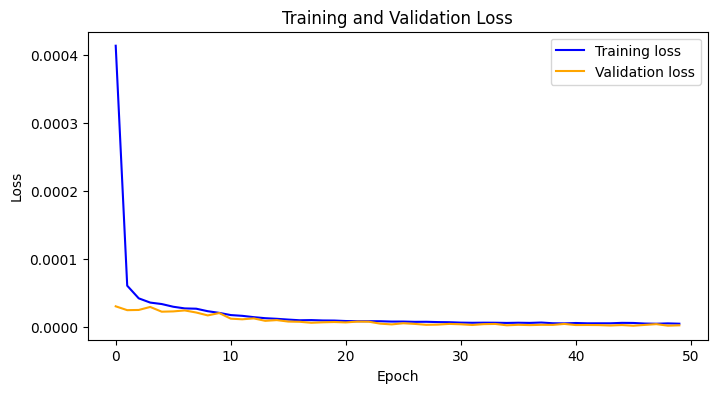

In [17]:
# Plot training history
data_analysis.plot_history(
    train_loss = model.history["loss"],
    valid_loss = model.history["val_loss"],
    title = "Training and Validation Loss",
    xlabel = "Epoch",
    ylabel = "Loss"
)

### Evaluation

In [ ]:
# Disable gradient computation for evaluation
with context_manager.no_grad():
    # Set the model in evaluation mode
    model.eval()
    
    # Compute the predictions
    X_test_out = model(X_test_norm, batch_size=batch_size, verbose=True)
    
    # Extract the predictions and squeeze the sequence dimension if necessary
    predictions = X_test_out.output

Processing batch 37/37 - 23.72 ms/step

In [ ]:
# Compute the mean absolute error on the test set
mae = metrics.mean_absolute_error(predictions, y_test)

# Print the test results
print(f"Test Results:")
print(f"Mean Absolute Error: {mae.to_numpy()}")

# Compute the directional accuracy
dir_acc = directional_accuracy(predictions.to_numpy(), y_test.to_numpy(), close_price_idx)

# Print the directional accuracy
print(f"Directional Accuracy: {dir_acc:.3f}")

Test Results:
Mean Absolute Error: 0.006132584530860186
Directional Accuracy: 0.927


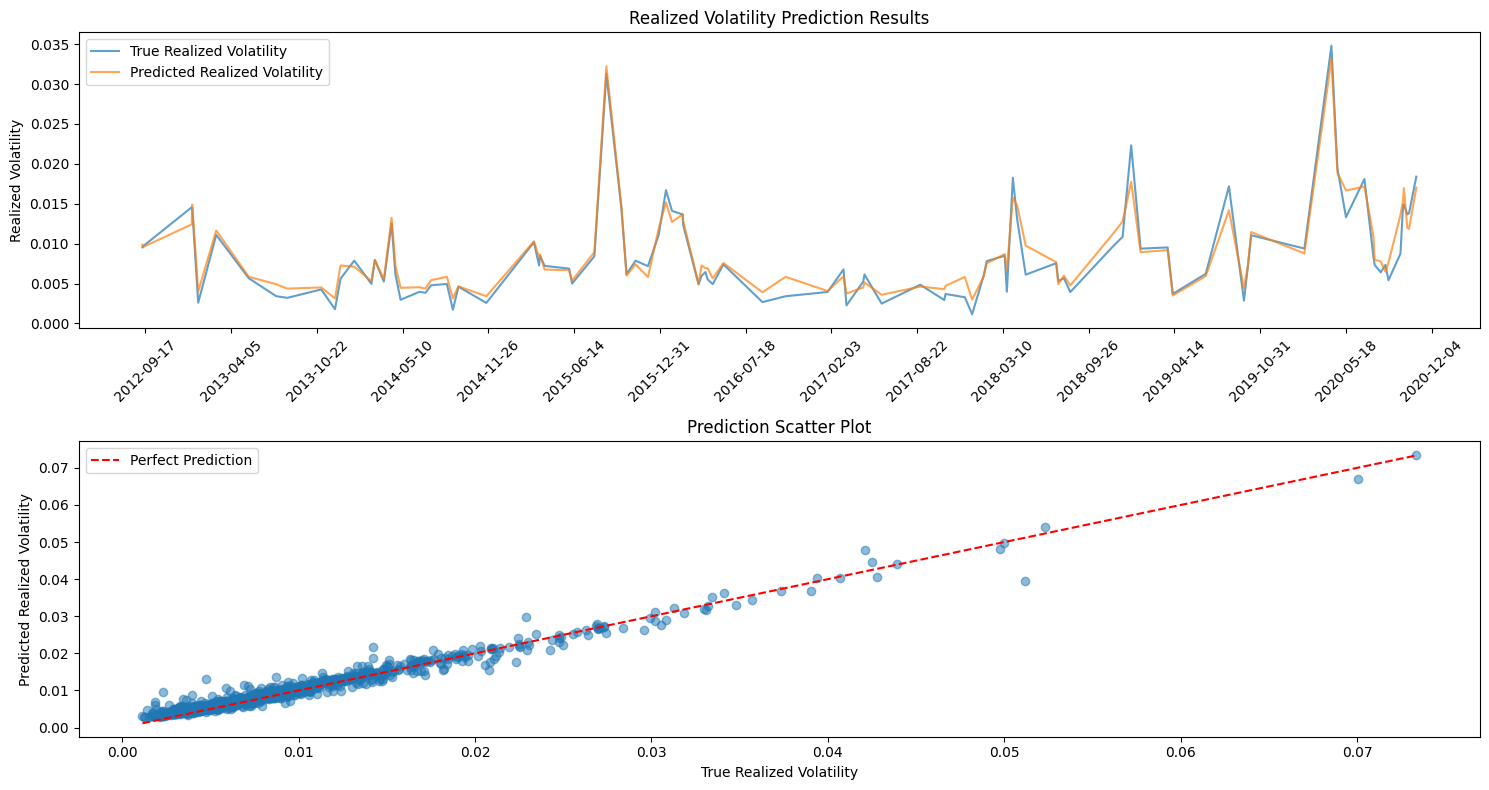

In [ ]:
# Prepare the plot object based on whether we are predicting volatility or log returns
plot_obj = "Realized Volatility"
samples_to_plot = 100  # Number of samples to plot

# Sort the test timestamps and corresponding predictions and true values
sorted_indices = np.argsort(test_timestamps.to_numpy())
sorted_test_timestamps = test_timestamps.to_numpy()[sorted_indices]
sorted_y_test = y_test.to_numpy()[sorted_indices]
sorted_predictions = predictions.to_numpy()[sorted_indices]

# Extract the test dates by converting timestamps to datetime
test_dates = np.array([datetime.fromtimestamp(int(t)) for t in sorted_test_timestamps])

# Create a figure for plotting
plt.figure(figsize=(15, 8))

# Plot the time series of true and predicted realized volatility
plt.subplot(2, 1, 1)
plt.plot(test_dates[-samples_to_plot:], sorted_y_test[-samples_to_plot:, close_price_idx], label=f'True {plot_obj}', alpha=0.7)
plt.plot(test_dates[-samples_to_plot:], sorted_predictions[-samples_to_plot:, close_price_idx], label=f'Predicted {plot_obj}', alpha=0.7)
plt.title(f'{plot_obj} Prediction Results')
plt.ylabel(plot_obj)
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

# Scatter plot of true vs predicted realized volatility
plt.subplot(2, 1, 2)
plt.scatter(y_test.to_numpy()[:, close_price_idx], predictions.to_numpy()[:, close_price_idx], alpha=0.5)
plt.plot(
    [y_test.to_numpy()[:, close_price_idx].min(), y_test.to_numpy()[:, close_price_idx].max()],
    [y_test.to_numpy()[:, close_price_idx].min(), y_test.to_numpy()[:, close_price_idx].max()],
    'r--', label='Perfect Prediction'
)
plt.xlabel(f'True {plot_obj}')
plt.ylabel(f'Predicted {plot_obj}')
plt.title('Prediction Scatter Plot')
plt.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()